In [1]:
import numpy as np

# scipy.special for the sigmoid function expit()
from scipy.special import expit

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
# neural network class definition
class NeuralNetwork:
    
    # initialize the neural network
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        
        # learning rate
        self.lr = learning_rate
        
        # link weight matrices, wih(Weight for input_hidden) and who(Weight for hidden_output)
        # weight inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))  # hnodes x inodes matrix
        self.who = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))  # onodes x hnodes matrix
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: expit(x)
        
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T   # inodes x 1 vector
        targets = np.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        # X_hidden = W_input_hidden * I
        hidden_inputs = np.dot(self.wih, inputs)
        
        # calculate the signals emerging from hidden layer
        # O_hidden = sigmoid(X_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final ouput layer
        # X_output = W_hidden_output * O_hidden
        final_inputs = np.dot(self.who, hidden_outputs)
        
        # calculate the signals emerging from final output layer
        # O_output = sigmoid(X_output)
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.who.T, output_errors)
        
        # update the weight for the links between the hidden and output layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        
        # update the weight for the links between the input and hidden layers
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T   # inodes x 1 vector
        
        # calculate signals into hidden layer
        # X_hidden = W_input_hidden * I
        hidden_inputs = np.dot(self.wih, inputs)
        
        # calculate the signals emerging from hidden layer
        # O_hidden = sigmoid(X_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final ouput layer
        # X_output = W_hidden_output * O_hidden
        final_inputs = np.dot(self.who, hidden_outputs)
        
        # calculate the signals emerging from final output layer
        # O_output = sigmoid(X_output)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

In [4]:
# load the mnist training data csv file into a list
with open('mnist_dataset/mnist_train.csv') as fobj:
    training_data_list = fobj.readlines()

In [5]:
# load the mnist test data CSV file into a list
with open('mnist_dataset/mnist_test.csv') as fobj:
    test_data_list = fobj.readlines()

In [6]:
# train the neural network
def fit_transform(estimator, training_data_list, epochs=1):
    # epochs is the number of times the training data set is used for training    
    for e in range(epochs):
        # go through all records in the training data set
        for record in training_data_list:
            # split the record by the ',' commas
            all_values = record.split(',')

            # scale and shift the inputs [0.01, 1]
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

            # create the target output values (all 0.01, except the desired label which is 0.99)
            targets = np.zeros(estimator.onodes) + 0.01

            # all_values[0] is the target label for this record
            targets[int(all_values[0])] = 0.99

            # train the neural network
            estimator.train(inputs, targets)    

In [7]:
# test the neural network
def predict(estimator, test_data_list):
    # scorecard for how well the network performs, initially empty
    scorecard = []

    # go through all records in the test data set
    for record in test_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')

        # correct answer is first value
        correct_label = int(all_values[0])

        # scale and shift the inputs [0.01, 1]
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

        # query the network
        outputs = estimator.query(inputs)

        # the index of the highest value corresponds to the label
        label = np.argmax(outputs)

        # append correct or incorrect to list
        if (label == correct_label):
            # network's answer matches correct answer, add 1 to scorecard
            scorecard.append(1)
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            scorecard.append(0)

    return scorecard

In [8]:
def grid_search(param_grid, training_data_list, test_data_list, cv=1):
    # number of input, hidden and output nodes
    input_nodes = 784
    output_nodes = 10
    results = []
    
    for hidden_nodes in param_grid['hidden_nodes']:
        for learning_rate in param_grid['learning_rate']:
            for epochs in param_grid['epochs']:
                dict_tmp = {}
                score = []
                for i in range(cv):
                    # create instance of neural network
                    n = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

                    fit_transform(n, training_data_list, epochs)  
                    scorecard = predict(n, test_data_list)

                    # calculate the performance score, the fraction of correct answers
                    scorecard_array = np.asarray(scorecard)
                    score.append(scorecard_array.sum() / scorecard_array.size)
            
                dict_tmp['hidden_nodes'] = hidden_nodes
                dict_tmp['learning_rate'] = learning_rate
                dict_tmp['epochs'] = epochs
                dict_tmp['performance'] = sum(score)/len(score)
                
                results.append(dict_tmp)
        
    return results

# Tweaking the Learning Rate

performance=  [0.9121333333333334, 0.9483333333333333, 0.9498000000000001, 0.9445333333333333, 0.9044, 0.8609333333333332]


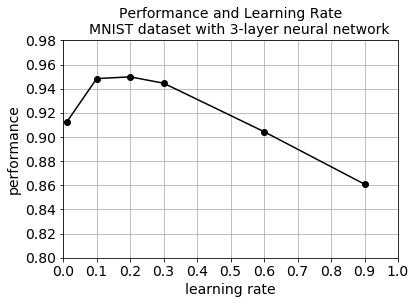

In [9]:
x_majorLocator = MultipleLocator(0.1)
y_majorLocator = MultipleLocator(0.02)

hidden_nodes = [100]
learning_rate = [0.01, 0.1, 0.2, 0.3, 0.6, 0.9]
epochs = [1]

param_grid = {'hidden_nodes': hidden_nodes, 'learning_rate': learning_rate, 'epochs':epochs}
results = grid_search(param_grid, training_data_list, test_data_list, cv=3)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.xaxis.set_major_locator(x_majorLocator)
ax.yaxis.set_major_locator(y_majorLocator)

ax.set_title("""Performance and Learning Rate
    MNIST dataset with 3-layer neural network""", fontsize=14)

ax.set_xlabel("learning rate", fontsize=14)
ax.set_ylabel("performance", fontsize=14)

ax.grid()
ax.axis([0, 1, 0.8, 0.98])
# ax.axis([0, 1, 0.4, 0.98])
ax.tick_params(axis='both', labelsize=14)

performance = []
for item in results:
    performance.append(item['performance'])

print('performance= ', performance)
ax.plot(learning_rate, performance, '-ok')

# Doing Multiple Runs

performance=  [0.9518333333333332, 0.9582, 0.9606666666666667, 0.9623333333333334, 0.9597333333333333, 0.9599333333333333, 0.9572666666666668, 0.9567333333333333]


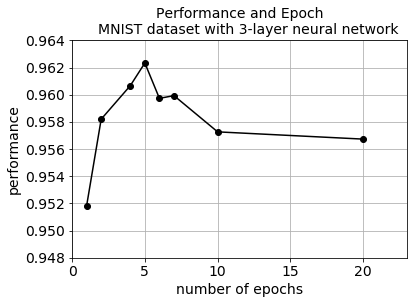

In [10]:
x_majorLocator = MultipleLocator(5)
y_majorLocator = MultipleLocator(0.002)

hidden_nodes = [100]
learning_rate = [0.2]
epochs = [1, 2, 4, 5, 6, 7, 10, 20]

param_grid = {'hidden_nodes': hidden_nodes, 'learning_rate': learning_rate, 'epochs':epochs}
results = grid_search(param_grid, training_data_list, test_data_list, cv=3)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.xaxis.set_major_locator(x_majorLocator)
ax.yaxis.set_major_locator(y_majorLocator)

ax.set_title("""Performance and Epoch
    MNIST dataset with 3-layer neural network""", fontsize=14)

ax.set_xlabel("number of epochs", fontsize=14)
ax.set_ylabel("performance", fontsize=14)

ax.grid()
ax.axis([0, 23, 0.948, 0.964])
# ax.axis([0, 23, 0.4, 0.98])
ax.tick_params(axis='both', labelsize=14)

performance = []
for item in results:
    performance.append(item['performance'])

print('performance= ', performance)
ax.plot(epochs, performance, '-ok')

# Doing Multiple Runs with Different Learning Rate

performance0 =  [0.9503, 0.9612333333333334, 0.9660666666666667, 0.9659666666666666, 0.9649000000000001, 0.9645, 0.9674333333333333, 0.9639666666666667]
performance1 =  [0.9483333333333334, 0.9548, 0.9604666666666667, 0.9612999999999999, 0.9603666666666667, 0.9562333333333334, 0.9572666666666666, 0.9516]


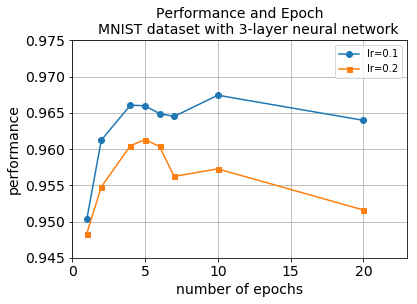

In [11]:
x_majorLocator = MultipleLocator(5)
y_majorLocator = MultipleLocator(0.005)

hidden_nodes = [100]
learning_rate = [0.1, 0.2]
epochs = [1, 2, 4, 5, 6, 7, 10, 20]

param_grid = {'hidden_nodes': hidden_nodes, 'learning_rate': learning_rate, 'epochs':epochs}
results = grid_search(param_grid, training_data_list, test_data_list, cv=3)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.xaxis.set_major_locator(x_majorLocator)
ax.yaxis.set_major_locator(y_majorLocator)

ax.set_title("""Performance and Epoch
    MNIST dataset with 3-layer neural network""", fontsize=14)

ax.set_xlabel("number of epochs", fontsize=14)
ax.set_ylabel("performance", fontsize=14)

ax.grid()
ax.axis([0, 23, 0.945, 0.975])
# ax.axis([0, 23, 0.4, 0.98])
ax.tick_params(axis='both', labelsize=14)

performance0 = []
performance1 = []
for item in results:
    if item['learning_rate'] == 0.1:
        performance0.append(item['performance'])
    else:
        performance1.append(item['performance'])

print('performance0 = ', performance0)
print('performance1 = ', performance1)
ax.plot(epochs, performance0, 'o-', label='lr=0.1')
ax.plot(epochs, performance1, 's-', ms='5', label='lr=0.2')
ax.legend()

# Change Network Shape

performance=  [0.7086, 0.8899333333333334, 0.9561999999999999, 0.9658333333333333, 0.9728, 0.9745666666666667]


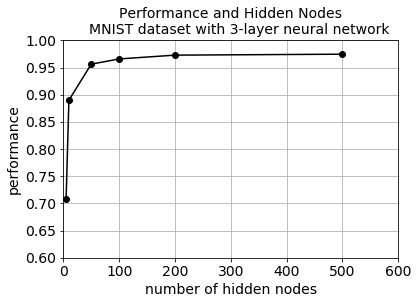

In [12]:
x_majorLocator = MultipleLocator(100)
y_majorLocator = MultipleLocator(0.05)

hidden_nodes = [5, 10, 50, 100, 200, 500]
learning_rate = [0.1]
epochs = [5]

param_grid = {'hidden_nodes': hidden_nodes, 'learning_rate': learning_rate, 'epochs':epochs}
results = grid_search(param_grid, training_data_list, test_data_list, cv=3)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.xaxis.set_major_locator(x_majorLocator)
ax.yaxis.set_major_locator(y_majorLocator)

ax.set_title("""Performance and Hidden Nodes
    MNIST dataset with 3-layer neural network""", fontsize=14)

ax.set_xlabel("number of hidden nodes", fontsize=14)
ax.set_ylabel("performance", fontsize=14)

ax.grid()
ax.axis([0, 600, 0.6, 1.0])
# ax.axis([0, 23, 0.4, 0.98])
ax.tick_params(axis='both', labelsize=14)

performance = []
for item in results:
    performance.append(item['performance'])

print('performance= ', performance)
ax.plot(hidden_nodes, performance, '-ok')